## Lab 2
### Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Our goal for today:
1. Train a FC network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network and demonstrate it in the appropriate way.
3. Try to deal with overfitting (at least partially) by using regularization techniques and demonstrate the results.


In [ ]:
import torch
import torch.nn as nn
from time import time
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [ ]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [ ]:
len(fmnist_dataset_test)

10000

In [ ]:
for img, label in train_loader:
    print(img.shape)
#    print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [ ]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards

            nn.Linear(input_shape, input_shape // 2),
            nn.BatchNorm1d(input_shape // 2, eps=1e-5),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 4),
            nn.ReLU(),
            nn.Linear(input_shape // 4, num_classes),
            nn.Dropout(0.5),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Flatten-2                  [-1, 784]               0
            Linear-3                  [-1, 392]         307,720
       BatchNorm1d-4                  [-1, 392]             784
              ReLU-5                  [-1, 392]               0
            Linear-6                  [-1, 196]          77,028
              ReLU-7                  [-1, 196]               0
            Linear-8                   [-1, 10]           1,970
           Dropout-9                   [-1, 10]               0
       LogSoftmax-10                   [-1, 10]               0
Total params: 387,502
Trainable params: 387,502
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.48
Estimated T

Your experiments come here:

In [ ]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

print(model)

TinyNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=784, out_features=392, bias=True)
    (3): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Linear(in_features=392, out_features=196, bias=True)
    (6): ReLU()
    (7): Linear(in_features=196, out_features=10, bias=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): LogSoftmax(dim=1)
  )
)


In [ ]:
def validate_one_epoch(net, test_loader, criterion):
    net.eval()
    loss_history = []
    acc_history = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            X_batch = x_batch.to(device)
            Y_batch = y_batch.to(device)

            # Forward
            predictions = net.forward(X_batch)
            loss = criterion(predictions, Y_batch)

            loss_history.append(loss.item())
            acc_history.append((torch.argmax(predictions, dim=1) == Y_batch).cpu().numpy().mean())
    return np.mean(loss_history), np.mean(acc_history)

In [ ]:
def train_one_epoch(net, train_loader, criterion, optimizer):
    net.train()
    loss_history = []
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch = x_batch.to(device)
        Y_batch = y_batch.to(device)

        # Forward
        predictions = net.forward(X_batch)
        loss = criterion(predictions, Y_batch)

        # Backward
        loss.backward()
        loss_history.append(loss.item())

        optimizer.step()

    return np.mean(loss_history)

In [ ]:
def train(train_loader, test_loader, net, optimizer, criterion, n_epoch = 30):
    times = []
    train_loss_history = []
    test_loss_history = []
    accuracy_history = []
    start_time = time()

    for i in range(n_epoch):
        epoch_train_loss = train_one_epoch(net, train_loader, criterion, optimizer)
        epoch_test_loss, epoch_accuracy = validate_one_epoch(net, test_loader, criterion)

        train_loss_history.append(epoch_train_loss)
        test_loss_history.append(epoch_test_loss)
        accuracy_history.append(epoch_accuracy)
        times.append(time() - start_time)
        print(f'epoch: {i}, accuracy: {accuracy_history[-1]}')

    return train_loss_history, test_loss_history, accuracy_history

In [ ]:
train_loss_history, test_loss_history, accuracy_history = train(train_loader, test_loader, model, opt, loss_func)

  3%|█▍                                          | 1/30 [00:08<04:01,  8.34s/it]

epoch: 0, accuracy: 0.8388671875


  7%|██▉                                         | 2/30 [00:17<04:05,  8.77s/it]

epoch: 1, accuracy: 0.858203125


 10%|████▍                                       | 3/30 [00:26<03:57,  8.79s/it]

epoch: 2, accuracy: 0.86376953125


 13%|█████▊                                      | 4/30 [00:34<03:43,  8.59s/it]

epoch: 3, accuracy: 0.84638671875


 17%|███████▎                                    | 5/30 [00:43<03:34,  8.58s/it]

epoch: 4, accuracy: 0.86865234375


 20%|████████▊                                   | 6/30 [00:52<03:31,  8.80s/it]

epoch: 5, accuracy: 0.876953125


 23%|██████████▎                                 | 7/30 [01:01<03:24,  8.90s/it]

epoch: 6, accuracy: 0.874609375


 27%|███████████▋                                | 8/30 [01:09<03:11,  8.70s/it]

epoch: 7, accuracy: 0.8759765625


 30%|█████████████▏                              | 9/30 [01:17<02:59,  8.55s/it]

epoch: 8, accuracy: 0.87744140625


 33%|██████████████▎                            | 10/30 [01:26<02:50,  8.54s/it]

epoch: 9, accuracy: 0.87158203125


 37%|███████████████▊                           | 11/30 [01:34<02:41,  8.52s/it]

epoch: 10, accuracy: 0.879296875


 40%|█████████████████▏                         | 12/30 [01:43<02:35,  8.61s/it]

epoch: 11, accuracy: 0.8833984375


 43%|██████████████████▋                        | 13/30 [01:52<02:26,  8.62s/it]

epoch: 12, accuracy: 0.87978515625


 47%|████████████████████                       | 14/30 [02:00<02:16,  8.55s/it]

epoch: 13, accuracy: 0.88046875


 50%|█████████████████████▌                     | 15/30 [02:09<02:08,  8.59s/it]

epoch: 14, accuracy: 0.88916015625


 53%|██████████████████████▉                    | 16/30 [02:18<02:00,  8.61s/it]

epoch: 15, accuracy: 0.88291015625


 57%|████████████████████████▎                  | 17/30 [02:26<01:51,  8.54s/it]

epoch: 16, accuracy: 0.87841796875


 60%|█████████████████████████▊                 | 18/30 [02:34<01:41,  8.49s/it]

epoch: 17, accuracy: 0.8763671875


 63%|███████████████████████████▏               | 19/30 [02:43<01:34,  8.60s/it]

epoch: 18, accuracy: 0.88662109375


 67%|████████████████████████████▋              | 20/30 [02:52<01:26,  8.64s/it]

epoch: 19, accuracy: 0.88486328125


 70%|██████████████████████████████             | 21/30 [03:01<01:17,  8.65s/it]

epoch: 20, accuracy: 0.878125


 73%|███████████████████████████████▌           | 22/30 [03:09<01:09,  8.64s/it]

epoch: 21, accuracy: 0.87314453125


 77%|████████████████████████████████▉          | 23/30 [03:18<01:00,  8.66s/it]

epoch: 22, accuracy: 0.8794921875


 80%|██████████████████████████████████▍        | 24/30 [03:27<00:52,  8.79s/it]

epoch: 23, accuracy: 0.88857421875


 83%|███████████████████████████████████▊       | 25/30 [03:36<00:44,  8.96s/it]

epoch: 24, accuracy: 0.89033203125


 87%|█████████████████████████████████████▎     | 26/30 [03:46<00:36,  9.13s/it]

epoch: 25, accuracy: 0.89208984375


 90%|██████████████████████████████████████▋    | 27/30 [03:56<00:27,  9.29s/it]

epoch: 26, accuracy: 0.87861328125


 93%|████████████████████████████████████████▏  | 28/30 [04:05<00:18,  9.26s/it]

epoch: 27, accuracy: 0.8865234375


 97%|█████████████████████████████████████████▌ | 29/30 [04:13<00:09,  9.08s/it]

epoch: 28, accuracy: 0.88525390625


100%|███████████████████████████████████████████| 30/30 [04:22<00:00,  8.75s/it]

epoch: 29, accuracy: 0.88271484375


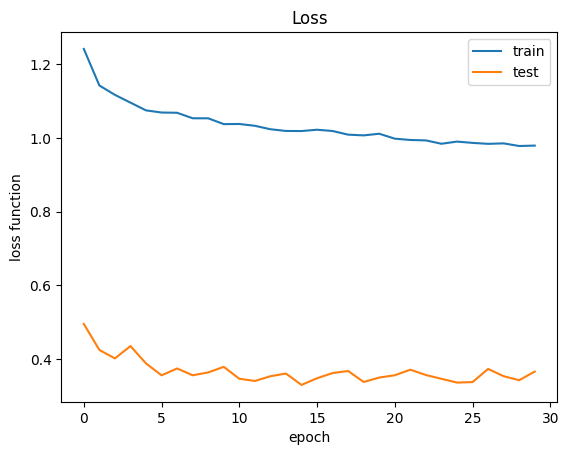

In [ ]:
plt.plot(np.arange(len(train_loss_history)), train_loss_history, label = 'train')
plt.plot(np.arange(len(test_loss_history)), test_loss_history, label = 'test')
plt.title('Loss')
plt.xlabel("epoch")
plt.ylabel("loss function")
plt.legend()
plt.show()

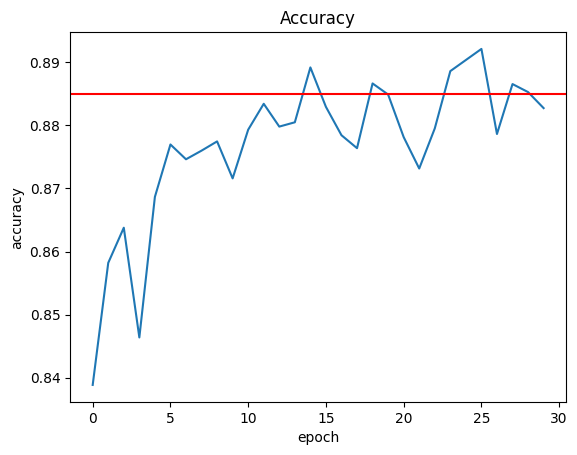

In [ ]:
plt.plot(np.arange(len(accuracy_history)), accuracy_history)
plt.axhline(y=0.885, color = 'r')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

We achieve the required accuracy after a certain number of epochs.
As for the loss function - there is a significant difference between test and train and test is smaller - most likely we have underfitting here

### Task 2: Overfit it.
Let's build a network that will overfit to this dataset and demonstrate the overfitting in the appropriate way

In [ ]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards

            nn.Linear(input_shape, input_shape // 2),
            nn.ReLU(),
            nn.Linear(input_shape // 2, input_shape // 4),
            nn.ReLU(),
            nn.Linear(input_shape // 4, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
              ReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 10]           1,970
        LogSoftmax-7                   [-1, 10]               0
Total params: 386,718
Trainable params: 386,718
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.48
Estimated Total Size (MB): 1.49
----------------------------------------------------------------


In [ ]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In [ ]:
train_loss_history, test_loss_history, accuracy_history = train(train_loader, test_loader, model, opt, loss_func)

epoch: 0, accuracy: 0.831640625
epoch: 1, accuracy: 0.8556640625
epoch: 2, accuracy: 0.84326171875
epoch: 3, accuracy: 0.843359375
epoch: 4, accuracy: 0.8677734375
epoch: 5, accuracy: 0.86162109375
epoch: 6, accuracy: 0.8673828125
epoch: 7, accuracy: 0.86669921875
epoch: 8, accuracy: 0.86201171875
epoch: 9, accuracy: 0.866015625
epoch: 10, accuracy: 0.87255859375
epoch: 11, accuracy: 0.8654296875
epoch: 12, accuracy: 0.8658203125
epoch: 13, accuracy: 0.8705078125
epoch: 14, accuracy: 0.8767578125
epoch: 15, accuracy: 0.86884765625
epoch: 16, accuracy: 0.86455078125
epoch: 17, accuracy: 0.872265625
epoch: 18, accuracy: 0.87138671875
epoch: 19, accuracy: 0.867578125
epoch: 20, accuracy: 0.86904296875
epoch: 21, accuracy: 0.8671875
epoch: 22, accuracy: 0.869140625
epoch: 23, accuracy: 0.86044921875
epoch: 24, accuracy: 0.87587890625
epoch: 25, accuracy: 0.879296875
epoch: 26, accuracy: 0.86884765625
epoch: 27, accuracy: 0.86767578125
epoch: 28, accuracy: 0.876171875
epoch: 29, accuracy: 0

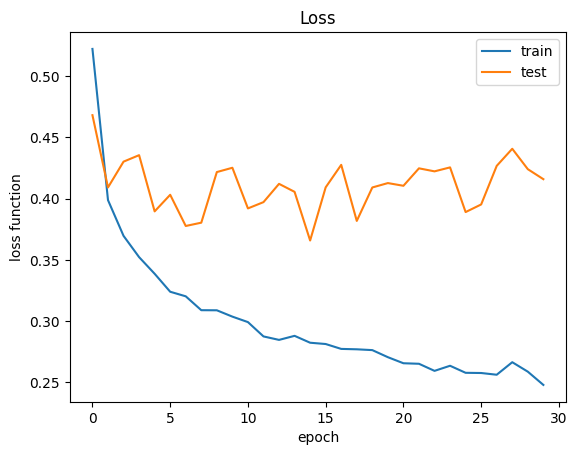

In [ ]:
plt.plot(np.arange(len(train_loss_history)), train_loss_history, label = 'train')
plt.plot(np.arange(len(test_loss_history)), test_loss_history, label = 'test')
plt.title('Loss')
plt.xlabel("epoch")
plt.ylabel("loss function")
plt.legend()
plt.show()

Here train loss becomes smaller with each epoch and improves the model. And test from some point does not decrease, but even increases. This means we have overfited the model

### Task 3: Fix it.
Let's fix the overfitted network from the previous step by using regularization techniques and demonstrate the results

In [ ]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards

            nn.Linear(input_shape * input_channels, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(400, 200),
            nn.BatchNorm1d(200,),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(200, 10)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [ ]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
       BatchNorm1d-3                  [-1, 400]             800
              ReLU-4                  [-1, 400]               0
           Dropout-5                  [-1, 400]               0
            Linear-6                  [-1, 200]          80,200
       BatchNorm1d-7                  [-1, 200]             400
              ReLU-8                  [-1, 200]               0
           Dropout-9                  [-1, 200]               0
           Linear-10                   [-1, 10]           2,010
Total params: 397,410
Trainable params: 397,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.52
Estimated T

In [ ]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.CrossEntropyLoss()

In [ ]:
train_loss_history, test_loss_history, accuracy_history = train(train_loader, test_loader, model, opt, loss_func, 20)

epoch: 0, accuracy: 0.8416015625
epoch: 1, accuracy: 0.8576171875
epoch: 2, accuracy: 0.8625
epoch: 3, accuracy: 0.86298828125
epoch: 4, accuracy: 0.87841796875
epoch: 5, accuracy: 0.8724609375
epoch: 6, accuracy: 0.8794921875
epoch: 7, accuracy: 0.87783203125
epoch: 8, accuracy: 0.87607421875
epoch: 9, accuracy: 0.8796875
epoch: 10, accuracy: 0.88037109375
epoch: 11, accuracy: 0.8873046875
epoch: 12, accuracy: 0.88408203125
epoch: 13, accuracy: 0.8875
epoch: 14, accuracy: 0.88583984375
epoch: 15, accuracy: 0.88935546875
epoch: 16, accuracy: 0.8775390625
epoch: 17, accuracy: 0.8826171875
epoch: 18, accuracy: 0.887890625
epoch: 19, accuracy: 0.88896484375


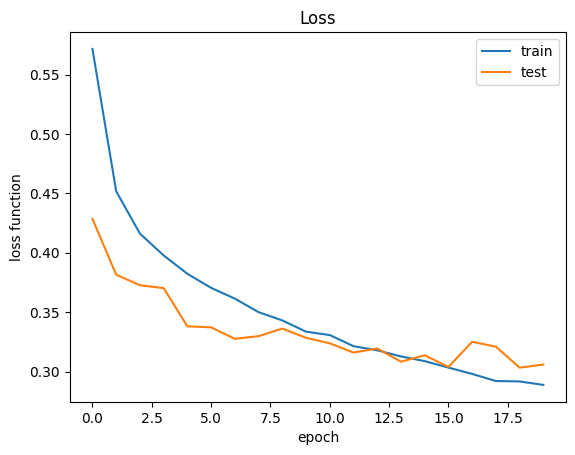

In [ ]:
plt.plot(np.arange(len(train_loss_history)), train_loss_history, label = 'train')
plt.plot(np.arange(len(test_loss_history)), test_loss_history, label = 'test')
plt.title('Loss')
plt.xlabel("epoch")
plt.ylabel("loss function")
plt.legend()
plt.show()

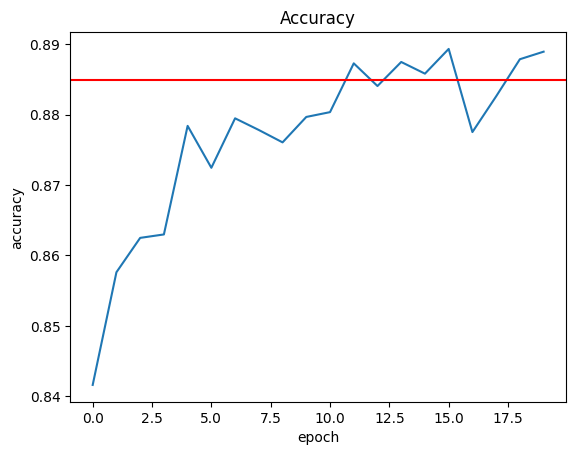

In [ ]:
plt.plot(np.arange(len(accuracy_history)), accuracy_history)
plt.axhline(y=0.885, color = 'r')
plt.title('Accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

Here both train and test decrease with each epoch. So we got rid of overfiting!

### Conclusions:

Without regularizators, our model can easily overfit. Dropout and BatchNorm helped get rid of this

The best accuracy value is about 0.8889

Also illustrated that if the test does not improve with each iteration, the model is overtrained